# Optimizing maximum scores of multiple submissions

We can submit the to leaderboard multiple times and our best submission counts. Therefore, it is not necessarily best to go for submissions with the largest expected score. If we create submissions with large variance and try many of them, can we get lucky?

I believe the answer is no! So don't expect too much here ;)

In this notebook, I try to estimate some stuff to show why I believe it's not a good idea. I create a simplified model of Santa's bag packing problem and optimize for the largest order statistic over a number of submissions. The outline is as follows:

1. Exploratory visualizations to understand the problem
2. Computing utility distributions of a large number of different kinds of bags
3. Packing bags and visualizing trade-off between mean and variance of score distributions
4. Creating random submissions

In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, gumbel_r
from scipy.optimize import linprog
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils.extmath import cartesian
%matplotlib inline

# 1. Exploration via sampling
Let's visualize distributions of individual items and bags.
We look at both their weights as well as their utilities (their contribution to the score).
Rules are that you need at least 3 items per bag and their combined weight must not exceed 50.

In [2]:
def sample_horse(size=1):
    return np.maximum(0, np.random.normal(5,2,size))

def sample_ball(size=1):
    return np.maximum(0, 1 + np.random.normal(1,0.3,size))

def sample_bike(size=1):
    return np.maximum(0, np.random.normal(20,10,size))

def sample_train(size=1):
    return np.maximum(0, np.random.normal(10,5,size))

def sample_coal(size=1):
    return 47 * np.random.beta(0.5,0.5,size)

def sample_book(size=1):
    return np.random.chisquare(2,size)

def sample_doll(size=1):
    return np.random.gamma(5,1,size)

def sample_block(size=1):
    return np.random.triangular(5,10,20,size)

def sample_gloves(size=1):
    dist1 = 3.0 + np.random.rand(size)
    dist2 = np.random.rand(size)
    toggle = np.random.rand(size) < 0.3
    dist2[toggle] = dist1[toggle]
    return dist2

samplers = {
    "horse": sample_horse,
    "ball": sample_ball,
    "bike": sample_bike,
    "train": sample_train,
    "coal": sample_coal,
    "book": sample_book,
    "doll": sample_doll,
    "blocks": sample_block,
    "gloves": sample_gloves
}

def sample(gift, quantity=1, size=1):
    return np.sum(samplers[gift](quantity * size).reshape(quantity, size), axis=0)

print(sample("horse", 2, 10))

[  9.27655874  10.64432554   8.87755635  10.31104769  10.07945332
   6.53904106  11.05740305   8.70047323   8.18155193   8.97980264]


Ok, so we can sample weights for individual gifts now and can also increase their quantities.
Let's combine different gifts into bags now.

In [3]:
def bag_name(bag):
    return str(list(map(lambda gift: "{}({})".format(gift, bag[gift]), sorted(bag.keys()))))

def create_bag_weight_sampler(bag):
    def bag_weight_sampler(size=1):
        weight = np.array([0.0]*size)
        for gift in sorted(bag.keys()):
            weight += sample(gift, bag[gift], size)
        return weight
    return bag_weight_sampler, bag_name(bag)

bag = { "horse": 1, "ball": 2 }
bag_weight_sampler, name = create_bag_weight_sampler(bag)
print("Sampling from bag {}: {}".format(name, bag_weight_sampler(3)))

Sampling from bag ['ball(2)', 'horse(1)']: [ 11.00033533   6.48913529   7.45838557]


Got the bag weight samplers, so let's see what the distributions look like:

['horse(1)']: mean=4.993946813192761 | std=1.996633324877951
['ball(1)']: mean=1.9999610260528669 | std=0.29926313156937207
['bike(1)']: mean=20.124567036112893 | std=9.708503858533955
['train(1)']: mean=10.096860157406196 | std=4.869808312140512
['coal(1)']: mean=23.58260868501139 | std=16.516622050153853
['book(1)']: mean=1.9651073829844155 | std=1.9856181023036743
['doll(1)']: mean=4.987135341910291 | std=2.2546879620353106
['blocks(1)']: mean=11.688418411569867 | std=3.1340615438180355
['gloves(1)']: mean=1.3999615958058886 | std=1.4035020425739941


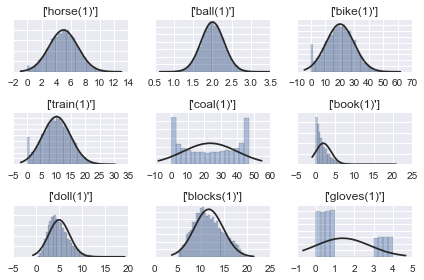

In [4]:
def plot_bag_weight_distributions(bags, size=10000):
    plot_distributions(bags, create_bag_weight_sampler, size=size, fit=norm)

def plot_distributions(bags, sampler_builder, size=10000, fit=None):
    num_plots = len(bags)
    num_cols = int(round(math.sqrt(num_plots)))
    num_rows = (num_plots // num_cols)
    num_rows = num_rows if num_plots % num_cols == 0 else num_rows + 1
    
    f, axes = plt.subplots(num_rows, num_cols)
    axes = axes.reshape(-1)
    for i in range(num_plots):
        current_bag = bags[i]
        current_bag_sampler, current_bag_name = sampler_builder(current_bag)
        current_sample = current_bag_sampler(size)
        print("{}: mean={} | std={}".format(current_bag_name, np.mean(current_sample), np.std(current_sample)))
        current_axis = axes[i]
        sns.distplot(current_sample, ax=current_axis, fit=fit, kde=False)
        current_axis.set_title(current_bag_name)
        current_axis.set_yticklabels([])
    plt.tight_layout()
    plt.show()
    
single_gift_bags = [
    {"horse": 1},
    {"ball": 1},
    {"bike": 1},
    {"train": 1},
    {"coal": 1},
    {"book": 1},
    {"doll": 1},
    {"blocks": 1},
    {"gloves": 1}
]

plot_bag_weight_distributions(single_gift_bags)

Note: some gift weight distributions are (almost) normal, others not at all.
Let's look at bigger bags now:

['ball(2)', 'horse(1)']: mean=8.976222091771112 | std=2.02818364422216
['bike(1)', 'train(3)']: mean=50.266706199972404 | std=12.935022935786147
['book(2)', 'coal(2)']: mean=51.30627208004272 | std=23.802869569528298
['book(12)', 'gloves(12)']: mean=40.67046507385622 | std=8.537311541575615


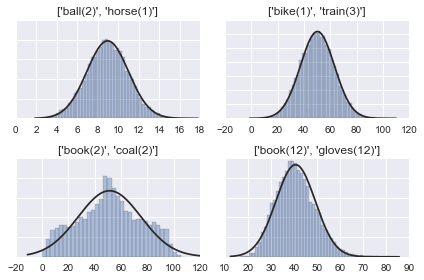

In [5]:
example_bags = [
    {"horse": 1, "ball": 2},
    {"train": 3, "bike": 1},
    {"coal": 2, "book": 2},
    {"gloves": 12, "book": 12},
]

plot_bag_weight_distributions(example_bags)

Nice :)
Even though individual gifts are not necessarily normal, big bags will almost certainly be (if we pack sufficiently many gifts into them).
Let's take a break to thank nature for the central limit theorem.
This is really cool because we can approximate the bag weight distribution by just summing up means and variances of the gift weight distributions.

Now: estimate how utilities of bags will be distributed.
I'll ignore the `enter code here`minimum count of 3 here and only do clipping at weight 50.

Sampling utility from bag ['ball(19)', 'horse(2)']: [ 46.04731982   0.          43.93051113]

['ball(2)', 'horse(1)']: mean=9.039102341332967 | std=2.0480430719634337
['bike(1)', 'train(3)']: mean=19.69264598925354 | std=20.494542628316285
['book(2)', 'coal(2)']: mean=14.954966650191928 | std=18.15446031157489
['book(12)', 'gloves(12)']: mean=33.17447717559809 | std=14.725342466629858


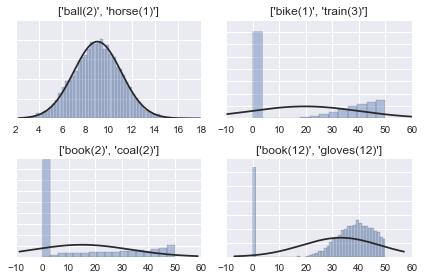

In [6]:
def plot_bag_utility_distributions(bags, size=10000, fit=norm):
    plot_distributions(bags, create_bag_utility_sampler, size=size, fit=fit)

def create_bag_utility_sampler(bag):
    bag_weight_sampler, bag_name = create_bag_weight_sampler(bag)
    def bag_utility_sampler(size=1):
        samples = bag_weight_sampler(size)
        samples[samples > 50] = 0
        return samples
    return bag_utility_sampler, bag_name

bag = { "horse": 2, "ball": 19 }
bag_utility_sampler, name = create_bag_utility_sampler(bag)
print("Sampling utility from bag {}: {}\n".format(name, bag_utility_sampler(3)))
plot_bag_utility_distributions(example_bags)

As expected, now that we clip at 50, distributions are again not at all normal because we get a lot of zeors (for bags with expected weighy close to 50, which we need for good scores).
Still, as we will pack a 1000 bags, the central limit theorem will again come to rescue and things will get back to normal when we add up many bags.
We will be able to approximate the final score distribution just by summing up means and variances of the bag utility distributions.
Thus, it makes sense to also characterize bag utilities by mean and standard deviation.

Let's now see what our score will be if we combine a lot of bags. One part is estimating the score distribution we will get from the bags. Furthermore, we will estimate what the best score would be if we could draw multiple times from that score distribution. This makes sense since we can submit to the leaderboard multiple times with randomly permuted gifts inside the bags. Hence, what we will get in the end is the best out of many trials.

Important to note: what I do below assumed iid draws from the score distributions.
For the leaderboard gift weights are fixed and we can only generate permutations of IDs.
Thus, the assumptions don't really hold. This will be a rather crude approximation to keep things simple.

Scores: mean = 76.22 | std = 31.50
Expected score after 60 trials: 143.45


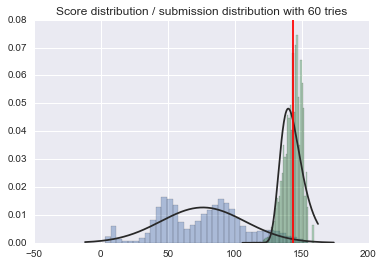

In [7]:
def plot_score_distribution(bags, num_tries=60, size=10000, fit=norm, extremal_fit=gumbel_r):
    scores = np.zeros(size)
    for i, bag in enumerate(bags):
        current_bag_sampler, _ = create_bag_utility_sampler(bag)
        scores += current_bag_sampler(size)
    score_mean, score_std = np.mean(scores), np.std(scores)
    print("Scores: mean = {:0.2f} | std = {:0.2f}".format(score_mean, score_std))
    sns.distplot(scores, fit=fit, kde=False)
    
    plot_extreme_value_distribution(scores, num_tries)
    plt.title("Score distribution / submission distribution with {} tries".format(num_tries))
    plt.show()

def plot_extreme_value_distribution(scores, num_tries, size=10000):
    samples = np.max(np.random.choice(scores, size=(size, num_tries)), axis=1)
    sns.distplot(samples, fit=gumbel_r, kde=False)
    expected_score = np.mean(samples)
    plt.axvline(expected_score, color='r')
    print("Expected score after {} trials: {:0.2f}".format(num_tries, expected_score))

plot_score_distribution(example_bags)

For our small set of 4 example bags, we not only get a crappy score but also the distribution does not look normal. But - interestingly - we can see that our score after 60 submissions would be a lot better than the score distribution's expected value.

What would happen if we could create 1000 bag
s of a certain kind? Also, let's verify that we can compute the score distribution from the means and variances of the bag utility distributions.

Computed statistics for 1000 bags: mean = 33274.53, std = 457.49
Scores: mean = 33125.83 | std = 462.09
Expected score after 60 trials: 34180.76


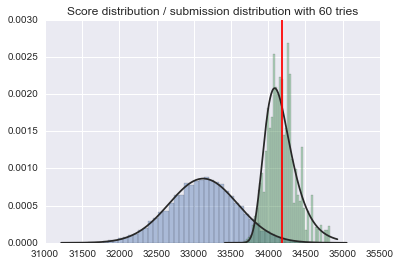

In [8]:
def n_bags(bag, n):
    return [bag for i in range(n)]

def estimate_mean_std_utility(bag, n=1, size=10000):
    current_bag_sampler, _ = create_bag_utility_sampler(bag)
    sample = current_bag_sampler(size)
    return np.mean(sample) * n, math.sqrt(math.pow(np.std(sample), 2) * n)

bag = {"gloves": 12, "book": 12}
n = 1000

est_bag_utility_mean, est_bag_utility_std = estimate_mean_std_utility(bag, n=n)
print("Computed statistics for {} bags: mean = {:0.2f}, std = {:0.2f}".format(n, est_bag_utility_mean, est_bag_utility_std))
plot_score_distribution(n_bags(bag, n))

Nice.
Computing and sampling delivers roughly the same (normal) score distribution.

## Summary

Main observations from the experiments above are:

- To get a weight distribution for individual bags, it is sufficient to add means and variances of individual gift weight distributions.
- Getting the utility distribution for bags requires sampling as there is no immediately available formula (that I would know of).
- Getting the overall score distribution can be done by adding means and variance of individual bag utility distributions.
- Getting an estimate of the expected final score after _n_ submissions can be done by sampling from score distribution (or probably also algebraically, but that does not matter too much imho)

# 2. Computing good bags
So let's start by finding bags with good utility distributions in three steps:

1. Get individual gift weight distributions: easy - just sample as there are so few
2. Get candiate bags: compute many weight distributions for many bags and eliminate most of them heuristically
3. Getting bag utility distributions: easy but inefficient - we use sampling for the candidate bags

## 2.1 Get individual gift weight distributions
As in 1., we just sample mean and variance for gift weights:

In [9]:
np.random.seed(42) # reset seed to make things reproducibe even if you fiddle around in the part above

def get_gift_weight_distributions(gifts, size=10000):
    def get_gift_weight_dsitribution(gift):
        sampler = samplers[gift]
        sample = sampler(size)
        return np.mean(sample), np.var(sample)
    
    distributions = np.zeros((len(gifts), 2))
    for i, gift in enumerate(gifts):
        distributions[i, :] = get_gift_weight_dsitribution(gift)
    return distributions

gifts = sorted(samplers.keys())
print("Canonical gift order: {}\n".format(gifts))
gift_weight_distributions = get_gift_weight_distributions(gifts)
print(pd.DataFrame(data=gift_weight_distributions, index=gifts, columns=["mean", "std"]))

Canonical gift order: ['ball', 'bike', 'blocks', 'book', 'coal', 'doll', 'gloves', 'horse', 'train']

             mean         std
ball     1.999359    0.090615
bike    20.229937   95.694407
blocks  11.613023    9.512805
book     2.005699    4.073323
coal    23.510956  277.100329
doll     5.006272    5.037590
gloves   1.414070    1.983514
horse    5.008280    3.892144
train   10.088743   24.050936


## 2.2 Get bag weight distributions
Next, we must create a list of bags we want to consider.
We do so by creating a numpy array with each row corresponding to a bag, each column to a gift type and the matrix itself to gift quantities per bag.
As it does not make much sense to increase expected weights beyond 50, we limit quantities correspondingly.

In [10]:
def get_mixed_item_bags_max_quantities(upper_limit=None):
    max_quantities = np.ceil(50 / gift_weight_distributions[:, 0])
    if upper_limit is not None:
        max_quantities[max_quantities > upper_limit] = upper_limit
    return max_quantities

mixed_item_max_quantities = get_mixed_item_bags_max_quantities()
print("maximum quantities:\n{}".format(np.dstack((np.array(gifts), mixed_item_max_quantities)).squeeze()))
print("number of different bags: {}".format(np.prod(mixed_item_max_quantities)))

maximum quantities:
[['ball' '26.0']
 ['bike' '3.0']
 ['blocks' '5.0']
 ['book' '25.0']
 ['coal' '3.0']
 ['doll' '10.0']
 ['gloves' '36.0']
 ['horse' '10.0']
 ['train' '5.0']]
number of different bags: 526500000.0


These are really a lot of combinations.
Let's limit the gift quantities by 11 to not explode to much here.
We can then manually add some bags consisting of lots of low weight gifts (balls, books and gloves) combined with very few gifts of other kinds.

In [11]:
mixed_item_max_quantities = get_mixed_item_bags_max_quantities(11)
print("maximum quantities:\n{}".format(np.dstack((np.array(gifts), mixed_item_max_quantities)).squeeze()))
print("number of different bags: {}".format(np.prod(mixed_item_max_quantities)))

maximum quantities:
[['ball' '11.0']
 ['bike' '3.0']
 ['blocks' '5.0']
 ['book' '11.0']
 ['coal' '3.0']
 ['doll' '10.0']
 ['gloves' '11.0']
 ['horse' '10.0']
 ['train' '5.0']]
number of different bags: 29947500.0


In [12]:
def create_candidate_bags(max_quantities):
    gift_counts = []
    for max_quantity in max_quantities:
        gift_counts.append(np.arange(max_quantity))
    return cartesian(gift_counts)

mixed_item_candiadte_bags = create_candidate_bags(mixed_item_max_quantities)
print("Created candiadate bags: {}".format(mixed_item_candiadte_bags.shape))

Created candiadate bags: (29947500, 9)


In [13]:
def get_bag_weight_distributions(candidate_bags, min_mean=30, max_mean=50):
    return np.dot(candidate_bags, gift_weight_distributions)

def filter_by_mean(bags, distributions, min_mean=30, max_mean=50):
    min_mask = mean_of(distributions) > min_mean
    distributions = distributions[min_mask]
    bags = bags[min_mask]
    max_mask = mean_of(distributions) < max_mean
    distributions = distributions[max_mask]
    bags = bags[max_mask]
    return bags, distributions

def mean_of(distributions):
    return distributions[:,0]

mixed_item_bag_weight_distributions = get_bag_weight_distributions(mixed_item_candiadte_bags)
mixed_item_candiadte_bags, mixed_item_bag_weight_distributions = \
    filter_by_mean(mixed_item_candiadte_bags, mixed_item_bag_weight_distributions)
print("Candidate bags left: {}".format(mixed_item_candiadte_bags.shape))

Candidate bags left: (58957, 9)


To these candidate bags, we now add bags that consist primarily of one of the 3 low weight items (ball / book / gloves), combined with few of the others:

In [14]:
def get_low_weight_item_candidate_bags():
    bags = []
    distributions = []
    for gift in ["ball", "book", "gloves"]:
        max_quantities = get_low_weight_item_bags_max_quantities_for(gift)
        candiadte_bags = create_candidate_bags(max_quantities)
        bags.append(candiadte_bags)
        cadidate_bag_weight_distributions = get_bag_weight_distributions(candiadte_bags)
        distributions.append(cadidate_bag_weight_distributions)
    return np.vstack(bags), np.vstack(distributions)
        

def get_low_weight_item_bags_max_quantities_for(gift):
    max_quantities = np.ceil(50 / gift_weight_distributions[:, 0])
    gift_index = gifts.index(gift)
    for i in range(len(max_quantities)):
        if not i == gift_index:
            max_quantities[i] = 5
    print("Gift {}: number of different bags: {}".format(gift, np.prod(max_quantities)))
    return max_quantities

low_weight_item_candidate_bags, low_weight_item_bag_weight_distributions = \
    filter_by_mean(*get_low_weight_item_candidate_bags())
print("Total number of canidate bags: {}".format(low_weight_item_candidate_bags.shape))

Gift ball: number of different bags: 10156250.0
Gift book: number of different bags: 9765625.0
Gift gloves: number of different bags: 14062500.0
Total number of canidate bags: (82817, 9)


In [15]:
def drop_duplicate(candidate_bags, distributions):
    df = pd.DataFrame(data=np.hstack((candidate_bags, distributions)), columns=gifts + ["mean", "std"])
    df.drop_duplicates(subset=gifts, inplace=True)
    return df[gifts].values, df[["mean", "std"]].values

candidate_bags = np.vstack([mixed_item_candiadte_bags, low_weight_item_candidate_bags])
bag_weight_distributions = np.vstack([mixed_item_bag_weight_distributions, low_weight_item_bag_weight_distributions])
print("Combined candiadte bags: {}".format(candidate_bags.shape))
candidate_bags, bag_weight_distributions = drop_duplicate(candidate_bags, bag_weight_distributions)
print("Final candidate bags without duplicates: {}".format(candidate_bags.shape))

Combined candiadte bags: (141774, 9)
Final candidate bags without duplicates: (71071, 9)


## 2.3 Get bag utility distributions
Now we use our sampler to estimate the utility distributions.
This will take a few minutes...

In [16]:
def get_bag_utility_distributions(candidate_bags):
    distributions = []
    size = len(candidate_bags)
    for i, candidate_bag in enumerate(candidate_bags):
        if i % 7000 == 0:
            sys.stdout.write("{:.4f}\r".format(float(i) / float(size)))
        distributions.append(get_bag_utility_distribution(candidate_bag))
    print("")
    return np.vstack(distributions)

def get_bag_utility_distribution(candidate_bag):
    bag = { gifts[i]: int(candidate_bag[i]) for i in range(len(gifts)) if candidate_bag[i] > 0 }
    sampler, name = create_bag_utility_sampler(bag)
    sample = sampler(10000)
    return np.mean(sample), np.var(sample)

bag_utility_distributions = get_bag_utility_distributions(candidate_bags)
print(bag_utility_distributions.shape)


(71071, 2)


# 3. Combining good bags to bag sets
Now we have a list of individual bags with their gift quantities and estimated utility distributions.
We can use these to create bag sets with their distributions.
Contsrained optimization is needed obey maximum gift number restrictions.
As long as we optimize the mean of the score distribution we can use linear programming.
If what we care for is the maximum order statistic though and we also like variance, it's not that easy.
Hence, we proceed in two steps:
- build a bag packer with LP that optimizes expected scores only but allows for a minimum variance constraint
- grid search over minimum variances and compare resulting score distributions by sampling expected maximum values

In [17]:
num_gifts_available = {
    "horse": 1000,
    "ball": 1100,
    "bike": 500,
    "train": 1000,
    "book": 1200,
    "doll": 1000,
    "blocks": 1000,
    "gloves": 200,
    "coal": 166
}

## 3.1 Packing bags with linear programming
Linear programming is not integer programming, so after solving the problem, we need to fiddle around a bit with the solution to make things work. The main strategy is:
- floor all bag quantities to get integer values
- increase maximum bags the algorithm packs until we get >= 1000 bags after flooring
- if that gives us > 1000 bags, just throw random bags away until we reach 1000

Sometimes when I run this, the solver thinks the problem is infeasible. The code also accounts for that and assigns 0 score in these cases. 

In [18]:
def pack_linprog(bags, distributions, min_variance, max_bags=1000):
    # objective: c.T * x -> min
    c = - distributions[:,0] # optimize sum of expected bag utilities
    
    # constraint: A_ub * x <= b_ub
    A_ub = bags.T # don't use more gifts than available
    b_ub = np.array([num_gifts_available[gift] for gift in gifts])
    
    A_ub = np.vstack([A_ub, np.ones(A_ub.shape[1])]) # pack at most max_bags gifts
    b_ub = np.hstack([b_ub, [max_bags]])
    
    if min_variance is not None:
        A_ub = np.vstack([A_ub, -distributions[:,1]]) # require minimum variance
        b_ub = np.hstack([b_ub, [-min_variance]])
    
    result = linprog(c, A_ub=A_ub, b_ub=b_ub)
    if result["success"] == False:
        return [], True
    else:
        return result["x"].astype('int64'), False


def pack_bags(bags, distributions, min_variance=None):
    max_bags = 1000
    bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance)
    while np.sum(bag_quantities) < 1000:
        max_bags += 1
        bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance, max_bags=max_bags)
        if max_bags > 1015:
            print("WARNING: not getting 1000 bags")
            break
        if infeasible:
            continue
    
    if infeasible:
        print("infeasible")
        return [], [], []
    
    chosen_bag_idx = np.where(bag_quantities)[0]
    chosen_bags = bags[chosen_bag_idx]
    chosen_distributions = distributions[chosen_bag_idx]
    chosen_quantities = bag_quantities[chosen_bag_idx]
    
    while np.sum(chosen_quantities) > 1000:
        idx = np.random.randint(len(chosen_quantities))
        chosen_quantities[idx] = max (chosen_quantities[idx]-1, 0)
    
    score_distribution = np.dot(chosen_quantities, chosen_distributions)
    print("{} bags - score distribution: mean = {:.2f} | var = {:.2f}"
          .format(np.sum(chosen_quantities), score_distribution[0], score_distribution[1]))
    
    return chosen_bags, chosen_distributions, chosen_quantities

packed_bags, packed_distributions, packed_quantities \
    = pack_bags(candidate_bags, bag_utility_distributions, min_variance=None)

1000 bags - score distribution: mean = 35573.17 | var = 104987.61


In [19]:
def evaluate_variances():
    results = {}
    for i, min_variance in enumerate(np.linspace(100000, 410000, num=10)):
        bags, distributions, quantities = pack_bags(candidate_bags, bag_utility_distributions, min_variance=min_variance)
        results[min_variance] = np.dot(quantities, distributions)
    return results

scores_for_min_variance = evaluate_variances()

1000 bags - score distribution: mean = 35566.60 | var = 105144.89
1000 bags - score distribution: mean = 35402.45 | var = 133794.76
1000 bags - score distribution: mean = 34927.61 | var = 168121.36
1000 bags - score distribution: mean = 34293.73 | var = 202784.93
1000 bags - score distribution: mean = 33564.48 | var = 236818.70
1000 bags - score distribution: mean = 32654.64 | var = 271188.18
1000 bags - score distribution: mean = 31687.87 | var = 305133.88
1000 bags - score distribution: mean = 30502.91 | var = 339435.77
1000 bags - score distribution: mean = 29160.63 | var = 373969.38
1000 bags - score distribution: mean = 27487.43 | var = 408261.02


100000.0 - 36318.58537778378
134444.44444444444 - 36251.28702608485
168888.88888888888 - 35879.25809406644
203333.33333333334 - 35338.69581367253
237777.77777777778 - 34693.71861016105
272222.22222222225 - 33861.99222276817
306666.6666666667 - 32968.36900222529
341111.1111111111 - 31855.88256598339
375555.55555555556 - 30578.748462581567
410000.0 - 28969.618397926675


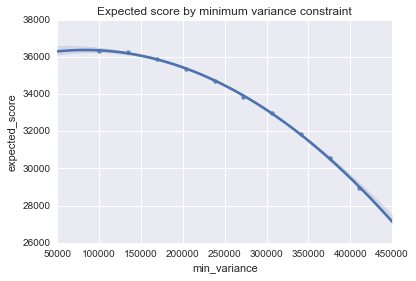

In [20]:
def plot_expected_scores_after(num_submissions, score_distributions):
    min_variances = sorted(score_distributions.keys())
    expected_scores = []
    for min_variance in min_variances:
        score_distribution = score_distributions[min_variance]
        if not type(score_distribution) == np.ndarray:
            expected_scores.append(0)
            continue
        samples = np.random.normal(score_distribution[0], math.sqrt(score_distribution[1]), (100000, num_submissions))
        expected_scores.append(np.mean(np.max(samples, axis=1)))
        print("{} - {}".format(min_variance, np.mean(np.max(samples, axis=1))))
    df = pd.DataFrame(data=np.hstack((np.expand_dims(min_variances, 1), np.expand_dims(expected_scores, 1))), columns=["min_variance", "expected_score"])
    sns.regplot(data=df, x="min_variance", y="expected_score", order=2)
    plt.title("Expected score by minimum variance constraint")

plot_expected_scores_after(60, scores_for_min_variance)

How sad: we cannot gain anything by increasing variance. It seems as if it's just best to optimize for expected score. Let's create submissions then.

# 4. Make submissions
We now create a lot of submissions with randomly permuted gifts and hope there is a good one among them.

In [25]:
np.random.seed(96)
def create_submissions(bags, quantities, num_submissions=60):
    def create_stock(n):
        stock = { gift: list(map(lambda id: "{}_{}".format(gift, id) ,np.arange(num_gifts_available[gift]))) for gift in gifts }
        return shuffle(stock, n)
    
    def shuffle(stock, seed):
        for gift in stock.keys():
            np.random.shuffle(stock[gift])
        return stock
    
    def generate_submission(n):
        stock = create_stock(n)
        with open("submission_{}.csv".format(n), 'w+') as submission_file:
            submission_file.write('Gifts\n')
            for i in range(len(bags)):
                for quantity in range(quantities[i]):
                    current_gifts = bags[i]
                    for gift_idx, gift_quantity in enumerate(current_gifts[:len(gifts)]):
                        gift_name = gifts[gift_idx]
                        for j in range(int(gift_quantity)):
                            submission_file.write("{} ".format(stock[gift_name].pop()))
                    submission_file.write("\n")
    
    for n in range(num_submissions):
        generate_submission(n)
        

create_submissions(packed_bags, packed_quantities)

In [26]:
pd.read_csv('submission_0.csv').head()

,Gifts
0,horse_400 horse_213 horse_623 horse_581 horse_...
1,horse_44 horse_269 horse_754 horse_599 horse_8...
2,horse_518 horse_662 horse_634 horse_390 horse_...
3,horse_898 horse_150 horse_217 horse_13 horse_4...
4,horse_858 horse_372 horse_183 horse_40 horse_2...
